In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)

# Setting up the environment

The next couple cells define global variables used throughout the notebook and ingest the training data that will be used to build a data model.

In [2]:
import os

# Set up some variables for the training data paths
BASE_DATA_PATH = os.path.join('..', 'data')
TRAIN_DATA_PATH = os.path.join(BASE_DATA_PATH, 'train')

TRAINING_PROVIDERS_PATH = os.path.join(TRAIN_DATA_PATH, 'Train-1542865627584.csv')
TRAINING_INPATIENT_PATH = os.path.join(TRAIN_DATA_PATH, 
    'Train_Inpatientdata-1542865627584.csv')
TRAINING_OUTPATIENT_PATH = os.path.join(TRAIN_DATA_PATH, 
    'Train_Outpatientdata-1542865627584.csv')
TRAINING_BENEFICIARY_PATH = os.path.join(TRAIN_DATA_PATH, 
    'Train_Beneficiarydata-1542865627584.csv')

# Defines the default behavior for responding to values that do not exist in data set
DEFAULT_NA_VALUE = "None"


In [3]:
# Read all of the training data

# List of providers
train_providers = pd.read_csv(TRAINING_PROVIDERS_PATH)

# Provides insights about the claims filed for those patients who are admitted in the hospitals
train_inpatient = pd.read_csv(TRAINING_INPATIENT_PATH)

# Provides details about the claims filed for those patients who visit hospitals and not admitted in it
train_outpatient = pd.read_csv(TRAINING_OUTPATIENT_PATH)

# Contains beneficiary KYC details like health conditions, region they belong to
train_beneficiary = pd.read_csv(TRAINING_BENEFICIARY_PATH)

In [4]:
# How similar are the inpatient/outpatient data? Let's see how many columns are
# unique between the two data sets
inp_unique_cols = [x for x in train_inpatient.columns if x not in train_outpatient.columns]
print(f'Unique columns in inpatient: {inp_unique_cols}')

outp_unique_cols = [x for x in train_outpatient.columns if x not in train_inpatient.columns]
print(f'Unique columns in outpatient: {outp_unique_cols}')

Unique columns in inpatient: ['AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode']
Unique columns in outpatient: []


# Merging claim data sets

Based on what we know about the columns in the inpatient/outpatient tables, we can safely merge those datasets with minimal disruption. Recommend combining all of the claims into a single dataframe that has all of the data from each table with the following columns added:
- Additional column for inpatient vs outpatient flag
- Columns unique to inpatient (i.e., AdmissionDt, DischargeDt, DiagnosisGroupCode)

In [5]:
# Add a flag to each of the data sets to indicate whether they came from the
# inpatient vs. outpatient frames
train_inpatient['In/Out'] = 'In'
train_outpatient['In/Out'] = 'Out'

# Use the concat operation to create a union of the two data sets. This 
# automatically handles any missing columns between the two sets, so no need
# to manually add missing columns to the outpatient data first.
train_claims = pd.concat([train_inpatient, train_outpatient], ignore_index=True)

train_claims

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,In
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,In
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,In
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,NaN,NaN,0.0,NaN,NaN,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,NaN,NaN,0.0,NaN,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out


# Merging patients with claims

Using the beneficiary column in the claim data, we can also populate details about the patient in each of the transactions.

This potentially allows us to engineer some additional features that are specific to beneficiaries across transactions. For example, how long has it been since a beneficiary's last claim?

In [6]:
# Do a left outer join in case there are any claims that don't have any corresponding beneficiaries
# defined in the beneficiary data set
train_claims = train_claims.merge(train_beneficiary, how='left', on='BeneID')
train_claims

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,In,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,In,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,In,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,NaN,NaN,0.0,NaN,NaN,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,NaN,NaN,0.0,NaN,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Out,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870


# Cleaning data

There are some fields that have empty data. We need a way to properly deal with those fields so that analysis can be performed.

It's probably too early to throw data out, so instead give these fields a friendly value like "None" and we can revisit whether we can throw them out entirely later.

## Cleanup in the next cell:
- In/Out column - Changed to boolean value, where 0 -> outpatient, 1-> inpatient
- (*)Physician columns - Remove PHY prefix from provider IDs

In [7]:
# Use apply() to map columns to new values that have been sanitized (i.e., transform from strings into numeric)
train_claims['In/Out'] = train_claims['In/Out'].apply(lambda x: 1 if x == 'In' else 0)

# The next few transforms require checks using pandas.isnull() to prevent errors for empty cells
train_claims['AttendingPhysician'] = train_claims['AttendingPhysician'].apply(lambda ap: ap.split('PHY')[-1] if not pd.isnull(ap) else ap)
train_claims['OperatingPhysician'] = train_claims['OperatingPhysician'].apply(lambda op: op.split('PHY')[-1] if not pd.isnull(op) else op)
train_claims['OtherPhysician'] = train_claims['OtherPhysician'].apply(lambda op: op.split('PHY')[-1] if not pd.isnull(op) else op)

train_claims

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,318495,318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,372395,NaN,324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,369659,392961,349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,379376,398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,364188,364188,385752,NaN,NaN,0.0,NaN,NaN,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,423019,332284,NaN,NaN,NaN,0.0,NaN,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,361063,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,403198,NaN,419379,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870


## Cleanup in the next cell:
- Some of the diagnosis code values are prefixed with a character. Remove them to make values numeric.

> **TODO: Decide whether we need to get all fancy pants and save off the various character flags
          that appear alongside the charge codes. Looks like 'E' and 'V' are the ones that show
          up most, but maybe there are others?**

> **TODO: Some resources online recommend using one-hot encoding to represent categorical data for decision tree algorithms:
https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree
Answer suggests one-hot is not super performant, but that might be acceptable since this data set isn't enormous...**

In [8]:
# Build list of diagnosis code columns
diagnosis_code_cols = [f'ClmDiagnosisCode_{x+1}' for x in range(10)]

# Strip ASCII characters from all of the claim diagnosis codes.
import string
for col in diagnosis_code_cols:
    train_claims[col] = train_claims[col].apply(lambda c: c.strip(string.ascii_letters) if not pd.isnull(c) else c)

# Check that all of the claim codes are now integers
assert sum([len([x for x in train_claims[col] if not pd.isnull(x) and not str(x).isdigit()]) for col in diagnosis_code_cols]) == 0

train_claims


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,318495,318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,372395,NaN,324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,369659,392961,349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,379376,398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,364188,364188,385752,NaN,NaN,0.0,NaN,NaN,2163,4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,423019,332284,NaN,NaN,NaN,0.0,NaN,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,361063,NaN,NaN,NaN,NaN,0.0,NaN,NaN,570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,403198,NaN,419379,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870


# Cleanup in the next cell:

Some of the deductible information has NaN. For now, set these values to 0.

> TODO: Is setting to 0 the right approach?

In [9]:
# Set NaN values, for deductible information, to 0  
train_claims['DeductibleAmtPaid'] = train_claims['DeductibleAmtPaid'].apply(lambda amt: 0 if pd.isnull(amt) else amt)

train_claims

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,318495,318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,372395,NaN,324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,369659,392961,349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,379376,398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,364188,364188,385752,NaN,NaN,0.0,NaN,NaN,2163,4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,423019,332284,NaN,NaN,NaN,0.0,NaN,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,361063,NaN,NaN,NaN,NaN,0.0,NaN,NaN,570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,403198,NaN,419379,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-04-01,NaN,2,1,0,21,20,12,12,1,1,2,2,2,1,1,2,2,1,2,0,0,5470,1870


# Feature Engineering

Features we can derive in the inpatient and outpatient datasets
- Claim duration
- Age of patient
- Is Dead flag
- Number of diagnoses
- Number of procedures
- Admission duration
- Has attending phys
- Has operating phys

In [10]:
from datetime import timedelta

# Calculate the age of the patient at the time their claim was initiated
train_claims['PatientAge'] = (pd.to_datetime(train_claims['ClaimStartDt'], format='%Y-%m-%d') - pd.to_datetime(train_claims['DOB'], format='%Y-%m-%d'))/timedelta(days=365)

# Calculate the duration of the patient's stay
train_claims['PatientStayDur'] = (pd.to_datetime(train_claims['DischargeDt'], format='%Y-%m-%d') - pd.to_datetime(train_claims['AdmissionDt'], format='%Y-%m-%d'))/timedelta(days=1)
train_claims['PatientStayDur'] = train_claims['PatientStayDur'].apply(lambda amt: 0 if pd.isnull(amt) else amt)

# Calculate the duration of the claim
train_claims['ClaimDur'] = (pd.to_datetime(train_claims['ClaimEndDt'], format='%Y-%m-%d') - pd.to_datetime(train_claims['ClaimStartDt'], format='%Y-%m-%d') + timedelta(days=1))/timedelta(days=1)
train_claims['ClaimDur'] = train_claims['ClaimDur'].apply(lambda amt: 0 if pd.isnull(amt) else amt)

# Define whether a patient is dead or not by giving a 0 if dead and 1 if still alive
train_claims['PatientDead'] = train_claims['DOD'].apply(lambda dod: 0 if pd.isnull(dod) else 1)


# Merging claim data with potential fraud indicators

Once we have all of our features in place, we should merge with the potential fraud data set.
This will let us set up independent/dependent variables for the decision tree to examine.

In [11]:
# Use a left outer join so we don't throw away providers that might not have claims.
train_total = train_providers.merge(train_claims, how='left', on='Provider')
train_total


,Provider,PotentialFraud,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Out,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PatientAge,PatientStayDur,ClaimDur,PatientDead
0,PRV51001,No,BENE36012,CLM58316,2009-07-04,2009-07-08,36000,340163,NaN,NaN,2009-07-04,29623,1068.0,2009-07-08,882,29650,2971,3051,1254,07070,28260,7823,49300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1940-07-01,NaN,1,1,0,1,510,12,12,2,1,1,2,2,1,1,1,2,2,1,36000,1068,3520,140,69.054795,4.0,5.0,0
1,PRV51001,No,BENE38773,CLM52334,2009-05-23,2009-05-25,12000,346762,NaN,NaN,2009-05-23,0389,1068.0,2009-05-25,864,0388,5849,2841,2762,7140,9444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1938-05-01,NaN,1,1,0,1,160,12,12,2,2,1,2,2,2,2,2,2,2,2,95000,2136,2270,900,71.109589,2.0,3.0,0
2,PRV51001,No,BENE98831,CLM36844,2009-02-03,2009-02-08,3000,383193,NaN,NaN,2009-02-03,5362,1068.0,2009-02-08,353,56211,5533,0088,5789,53081,27651,7840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1934-11-01,NaN,2,1,0,1,510,12,12,1,1,2,2,2,1,1,1,2,1,2,3000,1068,0,0,74.309589,5.0,6.0,0
3,PRV51001,No,BENE102690,CLM49733,2009-05-04,2009-05-18,42000,383193,378091,389113,2009-05-04,41401,1068.0,2009-05-18,245,4241,42731,4168,2724,4019,42822,2720,45829,53081,NaN,3521.0,2724.0,NaN,NaN,NaN,NaN,1,1929-11-01,NaN,2,1,Y,1,160,12,12,2,1,1,2,1,1,1,1,2,1,2,143800,4272,880,70,79.558904,14.0,15.0,0
4,PRV51001,No,BENE152088,CLM37205,2009-02-06,2009-02-06,4000,402229,329739,NaN,2009-02-06,80121,1068.0,2009-02-06,062,85222,2724,3310,40390,4501,5866,NaN,NaN,NaN,NaN,8659.0,NaN,NaN,NaN,NaN,NaN,1,1913-09-01,NaN,2,1,Y,1,160,12,12,1,1,1,1,1,1,1,1,2,1,1,111710,4272,80,70,95.498630,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,PRV57763,No,BENE148535,CLM582682,2009-09-16,2009-09-25,1100,321072,321072,321072,NaN,NaN,40.0,NaN,NaN,72740,78052,56942,71534,3540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1940-02-01,NaN,2,2,0,21,210,12,12,1,2,2,2,2,1,1,1,1,1,2,0,0,1780,320,69.671233,0.0,10.0,0
558207,PRV57763,No,BENE150998,CLM553988,2009-08-30,2009-08-30,200,321072,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1251,72981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1958-12-01,NaN,1,2,0,21,210,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,200,200,50.780822,0.0,1.0,0
558208,PRV57763,No,BENE151006,CLM610854,2009-10-02,2009-10-02,80,321072,321072,321072,NaN,NaN,0.0,NaN,NaN,79022,4011,427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1963-08-01,NaN,2,1,Y,21,210,12,12,2,2,1,1,1,2,1,1,2,2,2,28150,2136,1980,500,46.202740,0.0,1.0,0
558209,PRV57763,No,BENE158531,CLM691834,2009-11-20,2009-11-20,3300,321072,NaN,321072,NaN,NaN,0.0,NaN,NaN,41406,40290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1952-02-01,NaN,2,2,0,21,210,12,12,2,2,2,2,2,2,1,1,2,2,2,0,0,3700,240,57.841096,0.0,1.0,0


In [12]:
# Function that constructs a DataFrame of stats for given columns.
#    groupby_obj -> result of a groupby operation on a particular column
#    cols -> iterable of strings containing column names to calculate stats for
def stat_analysis(groupby_obj, cols):
    new_cols = []
    new_col_names = []
    for c in cols:
        new_cols += [groupby_obj[c].mean(), 
                     groupby_obj[c].median(),
                     groupby_obj[c].var().apply(lambda v: v if not pd.isnull(v) else 0),
                     groupby_obj[c].std().apply(lambda v: v if not pd.isnull(v) else 0),
                     groupby_obj[c].min(),
                     groupby_obj[c].max()]
        new_col_names += [f'Mean{c}',
                          f'Median{c}',
                          f'Var{c}',
                          f'Std{c}',
                          f'Min{c}',
                          f'Max{c}']
    
    return pd.DataFrame(data=zip(*new_cols), index=new_cols[0].index, columns=new_col_names)

# Group the data we've collected by provider so it can be analyzed with the stat_analysis function
train_total_gb = train_total.groupby(['Provider'])

# Calculate aggregated statistics on the selected columns
agg_frame = stat_analysis(train_total_gb, ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'PatientAge', 'Gender', 'Race', 'State', 'County', 'PatientStayDur', 'ClaimDur', 'PatientDead', 'IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt'])

# Join the aggregated stats frame with the fraud flag data
agg_frame = train_providers.merge(agg_frame, how='left', on='Provider')

# Set the index to the provider ID and drop the data from the Provider column
agg_frame = agg_frame.set_index(agg_frame['Provider'])
agg_frame = agg_frame.drop('Provider', axis=1)
agg_frame


,PotentialFraud,MeanInscClaimAmtReimbursed,MedianInscClaimAmtReimbursed,VarInscClaimAmtReimbursed,StdInscClaimAmtReimbursed,MinInscClaimAmtReimbursed,MaxInscClaimAmtReimbursed,MeanDeductibleAmtPaid,MedianDeductibleAmtPaid,VarDeductibleAmtPaid,StdDeductibleAmtPaid,MinDeductibleAmtPaid,MaxDeductibleAmtPaid,MeanPatientAge,MedianPatientAge,VarPatientAge,StdPatientAge,MinPatientAge,MaxPatientAge,MeanGender,MedianGender,VarGender,StdGender,MinGender,MaxGender,MeanRace,MedianRace,VarRace,StdRace,MinRace,MaxRace,MeanState,MedianState,VarState,StdState,MinState,MaxState,MeanCounty,MedianCounty,VarCounty,StdCounty,MinCounty,MaxCounty,MeanPatientStayDur,MedianPatientStayDur,VarPatientStayDur,StdPatientStayDur,MinPatientStayDur,MaxPatientStayDur,MeanClaimDur,MedianClaimDur,VarClaimDur,StdClaimDur,MinClaimDur,MaxClaimDur,MeanPatientDead,MedianPatientDead,VarPatientDead,StdPatientDead,MinPatientDead,MaxPatientDead,MeanIPAnnualReimbursementAmt,MedianIPAnnualReimbursementAmt,VarIPAnnualReimbursementAmt,StdIPAnnualReimbursementAmt,MinIPAnnualReimbursementAmt,MaxIPAnnualReimbursementAmt,MeanOPAnnualReimbursementAmt,MedianOPAnnualReimbursementAmt,VarOPAnnualReimbursementAmt,StdOPAnnualReimbursementAmt,MinOPAnnualReimbursementAmt,MaxOPAnnualReimbursementAmt
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,No,4185.600000,400,1.165556e+08,10796.091144,10,42000,213.600000,0.0,190104.000000,436.009174,0.0,1068.0,78.263014,79.558904,142.066116,11.919149,57.073973,97.539726,1.640000,2.0,0.240000,0.489898,1,2,1.160000,1.0,0.140000,0.374166,1,2,1.000000,1.0,0.000000,0.000000,1,1,460.000000,440.0,22866.666667,151.217283,160,660,1.000000,0.0,9.000000,3.000000,0.0,14.0,2.440000,1.0,11.340000,3.367492,1.0,15.0,0.000000,0.0,0.000000,0.000000,0,0,17606.000000,0,1.512858e+09,38895.477458,0,143800,2615.200000,1590,8.845726e+06,2974.176525,0,13460
PRV51003,Yes,4588.409091,1750,5.343310e+07,7309.794729,0,57000,502.166667,0.0,285778.384224,534.582439,0.0,1068.0,69.587422,71.686301,181.370344,13.467381,37.671233,96.958904,1.590909,2.0,0.243581,0.493539,1,2,1.212121,1.0,0.260005,0.509906,1,5,3.628788,1.0,17.945119,4.236168,1,11,300.386364,330.0,21198.330500,145.596465,20,851,2.424242,0.0,15.894980,3.986851,0.0,27.0,4.674242,2.5,30.419789,5.515414,1.0,28.0,0.007576,0.0,0.007576,0.087039,0,1,7568.181818,4580,1.008212e+08,10040.975578,0,57000,2678.181818,1235,2.694352e+07,5190.714819,0,31880
PRV51004,No,350.134228,70,4.760500e+05,689.963754,0,3300,2.080537,0.0,124.696173,11.166744,0.0,100.0,71.787570,72.830137,167.171740,12.929491,25.794521,99.758904,1.691275,2.0,0.214856,0.463525,1,2,1.228188,1.0,0.244876,0.494849,1,3,12.402685,1.0,204.566479,14.302674,1,52,327.181208,360.0,23424.433158,153.050427,10,770,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.429530,1.0,22.881825,4.783495,1.0,21.0,0.006711,0.0,0.006711,0.081923,0,1,4351.879195,0,9.780346e+07,9889.562978,0,51500,2194.899329,1140,1.022727e+07,3198.010914,0,20900
PRV51005,Yes,241.124464,70,2.416277e+05,491.556392,0,4080,3.175966,0.0,289.904576,17.026584,0.0,200.0,70.075247,70.731507,178.291931,13.352600,28.438356,100.887671,1.561373,2.0,0.246445,0.496432,1,2,1.242060,1.0,0.200807,0.448115,1,3,1.327897,1.0,7.529848,2.744057,1,25,483.880687,510.0,17536.749498,132.426393,110,660,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.088412,1.0,16.871043,4.107437,1.0,21.0,0.003433,0.0,0.003425,0.058520,0,1,3623.991416,0,9.386755e+07,9688.526566,0,144000,2109.733906,1200,1.568327e+07,3960.211085,10,97510
PRV51007,No,468.194444,80,2.055694e+06,1433.769116,0,10000,45.333333,0.0,46147.943662,214.820724,0.0,1068.0,68.837291,70.030137,214.170253,14.634557,26.010959,99.210959,1.527778,2.0,0.252739,0.502731,1,2,1.194444,1.0,0.158842,0.398550,1,2,3.000000,1.0,44.619718,6.679799,1,25,375.416667,380.0,1946.302817,44.116922,280,630,0.222222,0.0,1.217527,1.103416,0.0,7.0,1.958333,1.0,11.871479,3.445501,1.0,21.0,0.013889,0.0,0.013889,0.117851,0,1,3050.000000,0,3.229149e+07,5682.560175,0,24600,1729.722222,1290,

# Standard Deviation Calculations

With standard deviations now calculated for numeric fields, we can figure out how often claims are made beyond multiples of the standard deviation. This cell providers helper functions that perform that analysis against data internal to a provider, as well as comparing provider metrics against global mean/stddev

In [13]:
# Determines how many entries in a column are more than n std devs away from the mean
#   mean -> the mean to compare against
#   std_dev -> the std deviation to use
#   num_std_devs -> the number of standard deviations to use in calculations
#   col -> the column to apply calculations to
def num_std_devs_exceeded(mean, std_dev, num_std_devs, col):
    n = 0
    for entry in col:
        if entry > mean + num_std_devs * std_dev or entry < mean - num_std_devs * std_dev:
            n += 1

    return n

# Performs standard deviation analysis against previously collected statistics
#   index_name -> the name of the column to use as the index (in this notebook, 'Provider')
#   dev_result_col -> the name of the column to write calculations to
#   num_deviations -> the number of std devs to use in outlier analysis
#   stat_gen -> generator that yields a 4-tuple containing (current index, mean, std dev, column data) needed for calculations
def std_dev_analysis(index_name, dev_result_col, num_deviations, stat_gen):
    # Set up empty dictionary that maps index to a list of index values, and calculation results to a list of results
    result_dict = {index_name: [], dev_result_col: []}

    # For each group in the GroupBy object, get the mean and std dev, then calculate how many outliers there are.
    # Add the results to the result dictionary
    for key, mean, std_dev, column_data in stat_gen:
        outliers = num_std_devs_exceeded(mean, std_dev, num_deviations, column_data)

        result_dict[index_name].append(key)
        result_dict[dev_result_col].append(outliers)

    # Create a new DataFrame using the results of our calculations
    return pd.DataFrame(data=result_dict)

# Generator that provides the mean and std dev internal to a single provider
def internal_std_dev_generator(aggregated_analysis, group_by_obj, column):
    # Set up names for mean and std dev columns
    mean_key = f'Mean{column}'
    std_key = f'Std{column}'

    for key in group_by_obj.groups:
        mean = aggregated_analysis.loc[key][mean_key]
        std = aggregated_analysis.loc[key][std_key]

        yield (key, mean, std, group_by_obj.get_group(key)[column])

# Generator that provides the global mean and std dev regardless of provider
def global_std_dev_generator(global_data, group_by_obj, column):
    mean = global_data[column].mean()
    std = global_data[column].std()

    for key in group_by_obj.groups:
        yield (key, mean, std, group_by_obj.get_group(key)[column])

def internal_std_dev_to_frame(col, num_std_devs):
    internal_stat_gen = internal_std_dev_generator(agg_frame, train_total_gb, col)
    dev_frame = std_dev_analysis('Provider', f'{col}{num_std_devs}DeviationsInternal', num_std_devs, internal_stat_gen)

    return dev_frame

def global_std_dev_to_frame(col, num_std_devs):
    global_stat_gen = global_std_dev_generator(train_total, train_total_gb, col)
    dev_frame = std_dev_analysis('Provider', f'{col}{num_std_devs}DeviationsGlobal', num_std_devs, global_stat_gen)

    return dev_frame


# Select variables for std deviation analysis

The cell below uses the functions defined in the previous cell to perform outlier analysis of provider metrics against internal and global data

In [14]:
from functools import reduce
dev_frames = []

# Perform internal standard deviation analysis and merge results with the aggregated frame
dev_frames.append(internal_std_dev_to_frame('PatientAge', 1))
dev_frames.append(global_std_dev_to_frame('PatientAge', 1))
dev_frames.append(internal_std_dev_to_frame('InscClaimAmtReimbursed', 1))
dev_frames.append(global_std_dev_to_frame('InscClaimAmtReimbursed', 1))
dev_frames.append(internal_std_dev_to_frame('DeductibleAmtPaid', 1))
dev_frames.append(global_std_dev_to_frame('DeductibleAmtPaid', 1))
dev_frames.append(internal_std_dev_to_frame('IPAnnualReimbursementAmt', 1))
dev_frames.append(global_std_dev_to_frame('IPAnnualReimbursementAmt', 1))
dev_frames.append(internal_std_dev_to_frame('OPAnnualReimbursementAmt', 1))
dev_frames.append(global_std_dev_to_frame('OPAnnualReimbursementAmt', 1))

# Consolidate 
total_dev_frame = reduce(lambda left, right: left.merge(right, how='left', on='Provider'), dev_frames)

# Create final frame to be used in decision tree
final_frame = agg_frame.merge(total_dev_frame, how='left', on='Provider')
final_frame

,Provider,PotentialFraud,MeanInscClaimAmtReimbursed,MedianInscClaimAmtReimbursed,VarInscClaimAmtReimbursed,StdInscClaimAmtReimbursed,MinInscClaimAmtReimbursed,MaxInscClaimAmtReimbursed,MeanDeductibleAmtPaid,MedianDeductibleAmtPaid,VarDeductibleAmtPaid,StdDeductibleAmtPaid,MinDeductibleAmtPaid,MaxDeductibleAmtPaid,MeanPatientAge,MedianPatientAge,VarPatientAge,StdPatientAge,MinPatientAge,MaxPatientAge,MeanGender,MedianGender,VarGender,StdGender,MinGender,MaxGender,MeanRace,MedianRace,VarRace,StdRace,MinRace,MaxRace,MeanState,MedianState,VarState,StdState,MinState,MaxState,MeanCounty,MedianCounty,VarCounty,StdCounty,MinCounty,MaxCounty,MeanPatientStayDur,MedianPatientStayDur,VarPatientStayDur,StdPatientStayDur,MinPatientStayDur,MaxPatientStayDur,MeanClaimDur,MedianClaimDur,VarClaimDur,StdClaimDur,MinClaimDur,MaxClaimDur,MeanPatientDead,MedianPatientDead,VarPatientDead,StdPatientDead,MinPatientDead,MaxPatientDead,MeanIPAnnualReimbursementAmt,MedianIPAnnualReimbursementAmt,VarIPAnnualReimbursementAmt,StdIPAnnualReimbursementAmt,MinIPAnnualReimbursementAmt,MaxIPAnnualReimbursementAmt,MeanOPAnnualReimbursementAmt,MedianOPAnnualReimbursementAmt,VarOPAnnualReimbursementAmt,StdOPAnnualReimbursementAmt,MinOPAnnualReimbursementAmt,MaxOPAnnualReimbursementAmt,PatientAge1DeviationsInternal,PatientAge1DeviationsGlobal,InscClaimAmtReimbursed1DeviationsInternal,InscClaimAmtReimbursed1DeviationsGlobal,DeductibleAmtPaid1DeviationsInternal,DeductibleAmtPaid1DeviationsGlobal,IPAnnualReimbursementAmt1DeviationsInternal,IPAnnualReimbursementAmt1DeviationsGlobal,OPAnnualReimbursementAmt1DeviationsInternal,OPAnnualReimbursementAmt1DeviationsGlobal
0,PRV51001,No,4185.600000,400,1.165556e+08,10796.091144,10,42000,213.600000,0.0,190104.000000,436.009174,0.0,1068.0,78.263014,79.558904,142.066116,11.919149,57.073973,97.539726,1.640000,2.0,0.240000,0.489898,1,2,1.160000,1.0,0.140000,0.374166,1,2,1.000000,1.0,0.000000,0.000000,1,1,460.000000,440.0,22866.666667,151.217283,160,660,1.000000,0.0,9.000000,3.000000,0.0,14.0,2.440000,1.0,11.340000,3.367492,1.0,15.0,0.000000,0.0,0.000000,0.000000,0,0,17606.000000,0,1.512858e+09,38895.477458,0,143800,2615.200000,1590,8.845726e+06,2974.176525,0,13460,8,10,2,3,5,5,3,4,3,2
1,PRV51003,Yes,4588.409091,1750,5.343310e+07,7309.794729,0,57000,502.166667,0.0,285778.384224,534.582439,0.0,1068.0,69.587422,71.686301,181.370344,13.467381,37.671233,96.958904,1.590909,2.0,0.243581,0.493539,1,2,1.212121,1.0,0.260005,0.509906,1,5,3.628788,1.0,17.945119,4.236168,1,11,300.386364,330.0,21198.330500,145.596465,20,851,2.424242,0.0,15.894980,3.986851,0.0,27.0,4.674242,2.5,30.419789,5.515414,1.0,28.0,0.007576,0.0,0.007576,0.087039,0,1,7568.181818,4580,1.008212e+08,10040.975578,0,57000,2678.181818,1235,2.694352e+07,5190.714819,0,31880,39,43,17,46,62,62,16,16,9,10
2,PRV51004,No,350.134228,70,4.760500e+05,689.963754,0,3300,2.080537,0.0,124.696173,11.166744,0.0,100.0,71.787570,72.830137,167.171740,12.929491,25.794521,99.758904,1.691275,2.0,0.214856,0.463525,1,2,1.228188,1.0,0.244876,0.494849,1,3,12.402685,1.0,204.566479,14.302674,1,52,327.181208,360.0,23424.433158,153.050427,10,770,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.429530,1.0,22.881825,4.783495,1.0,21.0,0.006711,0.0,0.006711,0.081923,0,1,4351.879195,0,9.780346e+07,9889.562978,0,51500,2194.899329,1140,1.022727e+07,3198.010914,0,20900,50,47,15,0,6,0,16,14,14,13
3,PRV51005,Yes,241.124464,70,2.416277e+05,491.556392,0,4080,3.175966,0.0,289.904576,17.026584,0.0,200.0,70.075247,70.731507,178.291931,13.352600,28.438356,100.887671,1.561373,2.0,0.246445,0.496432,1,2,1.242060,1.0,0.200807,0.448115,1,3,1.327897,1.0,7.529848,2.744057,1,25,483.880687,510.0,17536.749498,132.426393,110,660,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.088412,1.0,16.871043,4.107437,1.0,21.0,0.003433,0.0,0.003425,0.058520,0,1,3623.991416,0,9.386755e+07,9688.526566,0,144000,2109.733906,1200,1.568327e+07,3960.211085,10,97510,306,305,92,0,45,0,90,57,49,49
4,PRV51007,No,468.194444,80,2.055694e+06,1433.769116,0,10000,45.333333,0.0,4

# Split training and test data

Separate training and test data prior to computing the decision tree


In [15]:
import math
cutoff = math.floor(len(final_frame) / 2)

train_final_frame = final_frame.iloc[:cutoff, :]
test_final_frame = final_frame.iloc[cutoff:, :]

train_final_frame
#test_final_frame


,Provider,PotentialFraud,MeanInscClaimAmtReimbursed,MedianInscClaimAmtReimbursed,VarInscClaimAmtReimbursed,StdInscClaimAmtReimbursed,MinInscClaimAmtReimbursed,MaxInscClaimAmtReimbursed,MeanDeductibleAmtPaid,MedianDeductibleAmtPaid,VarDeductibleAmtPaid,StdDeductibleAmtPaid,MinDeductibleAmtPaid,MaxDeductibleAmtPaid,MeanPatientAge,MedianPatientAge,VarPatientAge,StdPatientAge,MinPatientAge,MaxPatientAge,MeanGender,MedianGender,VarGender,StdGender,MinGender,MaxGender,MeanRace,MedianRace,VarRace,StdRace,MinRace,MaxRace,MeanState,MedianState,VarState,StdState,MinState,MaxState,MeanCounty,MedianCounty,VarCounty,StdCounty,MinCounty,MaxCounty,MeanPatientStayDur,MedianPatientStayDur,VarPatientStayDur,StdPatientStayDur,MinPatientStayDur,MaxPatientStayDur,MeanClaimDur,MedianClaimDur,VarClaimDur,StdClaimDur,MinClaimDur,MaxClaimDur,MeanPatientDead,MedianPatientDead,VarPatientDead,StdPatientDead,MinPatientDead,MaxPatientDead,MeanIPAnnualReimbursementAmt,MedianIPAnnualReimbursementAmt,VarIPAnnualReimbursementAmt,StdIPAnnualReimbursementAmt,MinIPAnnualReimbursementAmt,MaxIPAnnualReimbursementAmt,MeanOPAnnualReimbursementAmt,MedianOPAnnualReimbursementAmt,VarOPAnnualReimbursementAmt,StdOPAnnualReimbursementAmt,MinOPAnnualReimbursementAmt,MaxOPAnnualReimbursementAmt,PatientAge1DeviationsInternal,PatientAge1DeviationsGlobal,InscClaimAmtReimbursed1DeviationsInternal,InscClaimAmtReimbursed1DeviationsGlobal,DeductibleAmtPaid1DeviationsInternal,DeductibleAmtPaid1DeviationsGlobal,IPAnnualReimbursementAmt1DeviationsInternal,IPAnnualReimbursementAmt1DeviationsGlobal,OPAnnualReimbursementAmt1DeviationsInternal,OPAnnualReimbursementAmt1DeviationsGlobal
0,PRV51001,No,4185.600000,400,1.165556e+08,10796.091144,10,42000,213.600000,0.0,190104.000000,436.009174,0.0,1068.0,78.263014,79.558904,142.066116,11.919149,57.073973,97.539726,1.640000,2.0,0.240000,0.489898,1,2,1.160000,1.0,0.140000,0.374166,1,2,1.000000,1.0,0.000000,0.000000,1,1,460.000000,440.0,22866.666667,151.217283,160,660,1.000000,0.0,9.000000,3.000000,0.0,14.0,2.440000,1.0,11.340000,3.367492,1.0,15.0,0.000000,0.0,0.000000,0.000000,0,0,17606.000000,0,1.512858e+09,38895.477458,0,143800,2615.200000,1590,8.845726e+06,2974.176525,0,13460,8,10,2,3,5,5,3,4,3,2
1,PRV51003,Yes,4588.409091,1750,5.343310e+07,7309.794729,0,57000,502.166667,0.0,285778.384224,534.582439,0.0,1068.0,69.587422,71.686301,181.370344,13.467381,37.671233,96.958904,1.590909,2.0,0.243581,0.493539,1,2,1.212121,1.0,0.260005,0.509906,1,5,3.628788,1.0,17.945119,4.236168,1,11,300.386364,330.0,21198.330500,145.596465,20,851,2.424242,0.0,15.894980,3.986851,0.0,27.0,4.674242,2.5,30.419789,5.515414,1.0,28.0,0.007576,0.0,0.007576,0.087039,0,1,7568.181818,4580,1.008212e+08,10040.975578,0,57000,2678.181818,1235,2.694352e+07,5190.714819,0,31880,39,43,17,46,62,62,16,16,9,10
2,PRV51004,No,350.134228,70,4.760500e+05,689.963754,0,3300,2.080537,0.0,124.696173,11.166744,0.0,100.0,71.787570,72.830137,167.171740,12.929491,25.794521,99.758904,1.691275,2.0,0.214856,0.463525,1,2,1.228188,1.0,0.244876,0.494849,1,3,12.402685,1.0,204.566479,14.302674,1,52,327.181208,360.0,23424.433158,153.050427,10,770,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.429530,1.0,22.881825,4.783495,1.0,21.0,0.006711,0.0,0.006711,0.081923,0,1,4351.879195,0,9.780346e+07,9889.562978,0,51500,2194.899329,1140,1.022727e+07,3198.010914,0,20900,50,47,15,0,6,0,16,14,14,13
3,PRV51005,Yes,241.124464,70,2.416277e+05,491.556392,0,4080,3.175966,0.0,289.904576,17.026584,0.0,200.0,70.075247,70.731507,178.291931,13.352600,28.438356,100.887671,1.561373,2.0,0.246445,0.496432,1,2,1.242060,1.0,0.200807,0.448115,1,3,1.327897,1.0,7.529848,2.744057,1,25,483.880687,510.0,17536.749498,132.426393,110,660,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.088412,1.0,16.871043,4.107437,1.0,21.0,0.003433,0.0,0.003425,0.058520,0,1,3623.991416,0,9.386755e+07,9688.526566,0,144000,2109.733906,1200,1.568327e+07,3960.211085,10,97510,306,305,92,0,45,0,90,57,49,49
4,PRV51007,No,468.194444,80,2.055694e+06,1433.769116,0,10000,45.333333,0.0,4

# Define independent variables

Based on prior statistical evaluation and experimentation, we select independent variables to include in the model.

In [16]:
#features = ['MeanInscClaimAmtReimbursed', 'MeanDeductibleAmtPaid', 'StdInscClaimAmtReimbursed', 'StdDeductibleAmtPaid', 'InscClaimAmtReimbursed1Deviations', 'GlobalClaim1Deviations', 'MeanPatientAge', 'MeanGender', 'MeanRace', 'MeanState', 'MeanCounty', 'MeanPatientStayDur', 'MeanClaimDur']
#features = ['MeanInscClaimAmtReimbursed', 'MeanDeductibleAmtPaid', 'StdInscClaimAmtReimbursed', 'StdDeductibleAmtPaid', 'MeanPatientAge', 'MeanGender', 'MeanRace', 'MeanState', 'MeanCounty', 'MeanPatientStayDur', 'MeanClaimDur', 'PatientAge1DeviationsInternal', 'PatientAge1DeviationsGlobal', 'InscClaimAmtReimbursed3DeviationsInternal', 'InscClaimAmtReimbursed3DeviationsGlobal']

# TODO: This was good, see if we can do better
#features = ['MeanInscClaimAmtReimbursed', 'MedianInscClaimAmtReimbursed', 'StdInscClaimAmtReimbursed','MinInscClaimAmtReimbursed','MaxInscClaimAmtReimbursed','MeanDeductibleAmtPaid','MedianDeductibleAmtPaid','StdDeductibleAmtPaid','MinDeductibleAmtPaid','MaxDeductibleAmtPaid','MeanPatientAge','MedianPatientAge','StdPatientAge','MinPatientAge','MaxPatientAge','MeanGender','MeanRace','MaxPatientStayDur', 'MeanClaimDur','MaxClaimDur','PatientAge1DeviationsInternal','PatientAge1DeviationsGlobal','InscClaimAmtReimbursed1DeviationsInternal','InscClaimAmtReimbursed1DeviationsGlobal', 'VarIPAnnualReimbursementAmt', 'VarOPAnnualReimbursementAmt', 'MaxPatientDead']

# Even better
#features = ['MeanInscClaimAmtReimbursed', 'MedianInscClaimAmtReimbursed', 'StdInscClaimAmtReimbursed','MinInscClaimAmtReimbursed','MaxInscClaimAmtReimbursed','MeanPatientAge','MedianPatientAge','StdPatientAge','MinPatientAge','MaxPatientAge','MeanGender','MeanRace','MaxPatientStayDur', 'MeanClaimDur','MaxClaimDur','PatientAge1DeviationsInternal','PatientAge1DeviationsGlobal','InscClaimAmtReimbursed1DeviationsInternal','InscClaimAmtReimbursed1DeviationsGlobal', 'VarIPAnnualReimbursementAmt', 'VarOPAnnualReimbursementAmt']

features = ['MeanInscClaimAmtReimbursed', 'MedianInscClaimAmtReimbursed', 'StdInscClaimAmtReimbursed','MinInscClaimAmtReimbursed','MaxInscClaimAmtReimbursed','MeanPatientAge','MedianPatientAge','StdPatientAge','MinPatientAge','MaxPatientAge','MeanGender','MeanRace','MaxPatientStayDur', 'MeanClaimDur','MaxClaimDur','PatientAge1DeviationsInternal','PatientAge1DeviationsGlobal','InscClaimAmtReimbursed1DeviationsInternal','InscClaimAmtReimbursed1DeviationsGlobal', 'VarIPAnnualReimbursementAmt', 'VarOPAnnualReimbursementAmt']

##Cant have any chracters in these fields, must be numbers
X = train_final_frame.reindex(columns=features)
X

,MeanInscClaimAmtReimbursed,MedianInscClaimAmtReimbursed,StdInscClaimAmtReimbursed,MinInscClaimAmtReimbursed,MaxInscClaimAmtReimbursed,MeanPatientAge,MedianPatientAge,StdPatientAge,MinPatientAge,MaxPatientAge,MeanGender,MeanRace,MaxPatientStayDur,MeanClaimDur,MaxClaimDur,PatientAge1DeviationsInternal,PatientAge1DeviationsGlobal,InscClaimAmtReimbursed1DeviationsInternal,InscClaimAmtReimbursed1DeviationsGlobal,VarIPAnnualReimbursementAmt,VarOPAnnualReimbursementAmt
0,4185.600000,400,10796.091144,10,42000,78.263014,79.558904,11.919149,57.073973,97.539726,1.640000,1.160000,14.0,2.440000,15.0,8,10,2,3,1.512858e+09,8.845726e+06
1,4588.409091,1750,7309.794729,0,57000,69.587422,71.686301,13.467381,37.671233,96.958904,1.590909,1.212121,27.0,4.674242,28.0,39,43,17,46,1.008212e+08,2.694352e+07
2,350.134228,70,689.963754,0,3300,71.787570,72.830137,12.929491,25.794521,99.758904,1.691275,1.228188,0.0,2.429530,21.0,50,47,15,0,9.780346e+07,1.022727e+07
3,241.124464,70,491.556392,0,4080,70.075247,70.731507,13.352600,28.438356,100.887671,1.561373,1.242060,0.0,2.088412,21.0,306,305,92,0,9.386755e+07,1.568327e+07
4,468.194444,80,1433.769116,0,10000,68.837291,70.030137,14.634557,26.010959,99.210959,1.527778,1.194444,7.0,1.958333,21.0,19,24,4,2,3.229149e+07,2.636972e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,245.945946,100,478.449228,0,2500,79.183191,76.969863,11.699324,39.446575,97.934247,1.675676,1.108108,0.0,2.621622,21.0,11,11,2,0,2.594042e+08,5.446384e+06
2701,2091.000000,90,5793.796329,0,33000,71.313630,75.358904,13.320798,35.315068,94.473973,1.675000,1.100000,35.0,3.550000,36.0,9,10,3,5,1.580089e+08,2.023974e+07
2702,290.200000,65,664.531414,0,3300,73.640932,73.812329,15.392003,27.227397,99.008219,1.640000,1.200000,0.0,1.240000,11.0,14,15,3,0,3.220691e+08,1.882922e+06
2703,2135.937500,90,5376.007464,0,33000,74.067851,74.036986,10.115643,38.863014,97.246575,1.625000,1.046875,17.0,3.281250,21.0,16,11,5,9,7.415346e+07,9.417848e+06


# Define dependent variables

Define the dependent variables that we are trying to predict

In [17]:
Y = train_final_frame['PotentialFraud']
Y

0        No
1       Yes
2        No
3       Yes
4        No
       ... 
2700     No
2701    Yes
2702     No
2703     No
2704     No
Name: PotentialFraud, Length: 2705, dtype: object

# Compute decision tree

Use the sklearn implementation of the decision tree classifier algorithm to build a decision tree from training data

In [18]:
#import decision tree
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn import tree, ensemble

#clf = tree.DecisionTreeClassifier(random_state=0)
clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=0, max_depth=20)

##Cant have any chracters in these fields, must be numbers
clf = clf.fit(X, Y)
clf

The scikit-learn version is 0.23.2.


RandomForestClassifier(max_depth=20, random_state=0)

In [19]:
import numpy as np
sorted_out = Y.unique()
sorted_out = np.sort(sorted_out)
sorted_out = list(map(str, sorted_out))

'''
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size

print(clf.get_n_leaves())

plot = tree.plot_tree(clf, rounded=True, filled=True, class_names=sorted, feature_names=features, max_depth=2)
'''

'\nimport matplotlib.pyplot as plt\n\nfig_size = plt.rcParams["figure.figsize"]\nfig_size[0] = 20\nfig_size[1] = 20\nplt.rcParams["figure.figsize"] = fig_size\n\nprint(clf.get_n_leaves())\n\nplot = tree.plot_tree(clf, rounded=True, filled=True, class_names=sorted, feature_names=features, max_depth=2)\n'

In [20]:
XTest = test_final_frame.loc[:,features]
XTest

,MeanInscClaimAmtReimbursed,MedianInscClaimAmtReimbursed,StdInscClaimAmtReimbursed,MinInscClaimAmtReimbursed,MaxInscClaimAmtReimbursed,MeanPatientAge,MedianPatientAge,StdPatientAge,MinPatientAge,MaxPatientAge,MeanGender,MeanRace,MaxPatientStayDur,MeanClaimDur,MaxClaimDur,PatientAge1DeviationsInternal,PatientAge1DeviationsGlobal,InscClaimAmtReimbursed1DeviationsInternal,InscClaimAmtReimbursed1DeviationsGlobal,VarIPAnnualReimbursementAmt,VarOPAnnualReimbursementAmt
2705,4927.484277,2000,8000.059997,0,57000,73.512118,74.693151,13.574757,26.487671,100.701370,1.569182,1.157233,28.0,4.526730,29.0,165,174,70,225,2.451639e+08,1.857513e+07
2706,412.181818,90,807.856357,0,5000,72.318655,71.683562,11.599111,38.824658,96.334247,1.654545,1.172727,4.0,2.309091,21.0,37,31,10,1,1.081247e+08,1.445525e+07
2707,233.535912,70,504.024564,0,3300,72.754348,75.336986,13.806244,35.608219,98.805479,1.624309,1.132597,0.0,1.475138,21.0,42,42,15,0,4.341742e+07,1.329415e+07
2708,267.096774,100,422.967245,0,1900,73.421211,74.567123,9.518908,46.145205,88.506849,1.483871,1.354839,0.0,3.290323,21.0,8,3,4,0,1.179252e+08,2.348963e+07
2709,416.202845,80,1749.590349,0,49000,72.770478,73.476712,13.543580,25.791781,100.205479,1.627706,1.097093,21.0,2.312925,22.0,421,445,63,18,1.220265e+08,1.449363e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,380.000000,65,820.880286,10,3300,73.476419,72.553425,8.788619,55.863014,89.282192,1.428571,1.642857,0.0,3.142857,21.0,8,6,3,0,7.539154e+07,1.821784e+07
5406,216.818182,85,309.998254,20,1100,61.016438,58.689041,9.804038,43.383562,82.449315,1.227273,1.181818,0.0,1.318182,8.0,6,12,2,0,1.216344e+07,2.063478e+06
5407,225.243902,70,418.366092,0,2200,71.545306,73.606849,16.522107,30.145205,98.682192,1.512195,1.304878,0.0,2.390244,21.0,23,28,9,0,2.169850e+08,1.946157e+07
5408,1900.000000,1900,0.000000,1900,1900,67.786301,67.786301,0.000000,67.786301,67.786301,1.000000,1.000000,0.0,1.000000,1.0,0,0,0,0,0.000000e+00,0.000000e+00


In [21]:
YTest = test_final_frame["PotentialFraud"]
YTest

2705    Yes
2706     No
2707     No
2708     No
2709    Yes
       ... 
5405     No
5406     No
5407     No
5408     No
5409     No
Name: PotentialFraud, Length: 2705, dtype: object

In [22]:
YPredicted = clf.predict(XTest)
YPredicted

array(['Yes', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [23]:
from sklearn import metrics
accuracy = metrics.accuracy_score(YTest,YPredicted)
accuracy

0.9393715341959334

[30.0, 5.0]
[[2401   45]
 [ 119  140]]


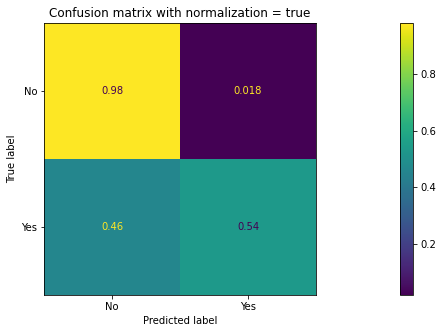

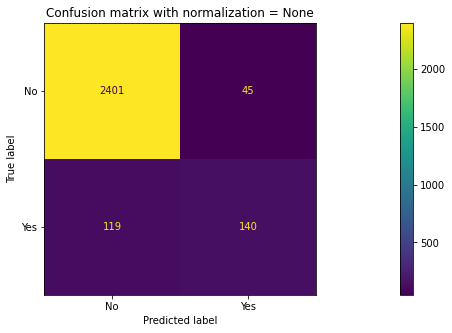

In [24]:
#setup plots for confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix as matrix
figSize = plt.rcParams["figure.figsize"]
figSize[0] = 30
figSize[1] = 5
plt.rcParams["figure.figsize"]=figSize
print(plt.rcParams.get('figure.figsize'))

#plot the confusion matrices 1 for normalzied the other un-normalized
values = ['true',None]
#cmap='cividis'
for x in values:
    disp = matrix(clf,XTest,YTest,display_labels=sorted_out,normalize=x)
    disp.ax_.set_title("Confusion matrix with normalization = "+str(x))
print(disp.confusion_matrix)

In [25]:
#get false positives
#pd.set_option('display.max_rows',100)
test_final_frame["PotentialFraud"][(YTest!=YPredicted)&(YPredicted=="Yes")]

2724    No
2862    No
2871    No
3075    No
3103    No
        ..
5042    No
5059    No
5115    No
5217    No
5369    No
Name: PotentialFraud, Length: 45, dtype: object

In [26]:
#get false negative
#pd.set_option('display.max_rows',100)
test_final_frame["PotentialFraud"][(YTest!=YPredicted)&(YPredicted=="No")]

2722    Yes
2725    Yes
2729    Yes
2811    Yes
2812    Yes
       ... 
5215    Yes
5231    Yes
5248    Yes
5324    Yes
5329    Yes
Name: PotentialFraud, Length: 119, dtype: object

In [27]:
sorted([x for x in zip(clf.feature_importances_, features)], key=lambda x: x[0])

[(0.0030701113969613635, 'MinInscClaimAmtReimbursed'),
 (0.016144698204301762, 'MedianInscClaimAmtReimbursed'),
 (0.025005757074154582, 'StdPatientAge'),
 (0.02516604938046355, 'MeanRace'),
 (0.02546042313164704, 'MeanPatientAge'),
 (0.025773712643169803, 'MedianPatientAge'),
 (0.030484206671636795, 'MeanClaimDur'),
 (0.030747598743105033, 'VarOPAnnualReimbursementAmt'),
 (0.03137922959864254, 'MeanGender'),
 (0.03298503932607451, 'MinPatientAge'),
 (0.03392038717657601, 'VarIPAnnualReimbursementAmt'),
 (0.034143801460704344, 'MaxPatientAge'),
 (0.03995182180328627, 'MeanInscClaimAmtReimbursed'),
 (0.04693437672591203, 'StdInscClaimAmtReimbursed'),
 (0.057537119697738476, 'InscClaimAmtReimbursed1DeviationsInternal'),
 (0.06275919644651706, 'PatientAge1DeviationsInternal'),
 (0.06579234327767974, 'PatientAge1DeviationsGlobal'),
 (0.08954435437291107, 'MaxInscClaimAmtReimbursed'),
 (0.10549952837761932, 'MaxClaimDur'),
 (0.10800641334533463, 'MaxPatientStayDur'),
 (0.10969383114556402, '